# Azerbaijan Grand Prix 2024

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

import fastf1.plotting

# Load FastF1's dark color scheme
# fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False, color_scheme='fastf1')

import plotly.graph_objects as go
import fastf1.plotting

In [2]:
import sys

sys.path.append('../')

from src.race_support import *

In [3]:
# fastf1.Cache.enable_cache('path/to/cache')

In [221]:
session = fastf1.get_session(2024, 17, 'R')
session.load(telemetry=True, weather=True)

core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']


In [231]:
session.results

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
81,81,O PIASTRI,PIA,piastri,McLaren,FF8000,mclaren,Oscar,Piastri,Oscar Piastri,...,AUS,1.0,1,2.0,NaT,NaT,NaT,0 days 01:32:58.007000,Finished,25.0
16,16,C LECLERC,LEC,leclerc,Ferrari,E80020,ferrari,Charles,Leclerc,Charles Leclerc,...,MON,2.0,2,1.0,NaT,NaT,NaT,0 days 00:00:10.910000,Finished,18.0
63,63,G RUSSELL,RUS,russell,Mercedes,27F4D2,mercedes,George,Russell,George Russell,...,GBR,3.0,3,5.0,NaT,NaT,NaT,0 days 00:00:31.328000,Finished,15.0
4,4,L NORRIS,NOR,norris,McLaren,FF8000,mclaren,Lando,Norris,Lando Norris,...,GBR,4.0,4,15.0,NaT,NaT,NaT,0 days 00:00:36.143000,Finished,13.0
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,...,NED,5.0,5,6.0,NaT,NaT,NaT,0 days 00:01:17.098000,Finished,10.0
14,14,F ALONSO,ALO,alonso,Aston Martin,229971,aston_martin,Fernando,Alonso,Fernando Alonso,...,ESP,6.0,6,7.0,NaT,NaT,NaT,0 days 00:01:25.468000,Finished,8.0
23,23,A ALBON,ALB,albon,Williams,64C4FF,williams,Alexander,Albon,Alexander Albon,...,THA,7.0,7,9.0,NaT,NaT,NaT,0 days 00:01:27.396000,Finished,6.0
43,43,F COLAPINTO,COL,colapinto,Williams,64C4FF,williams,Franco,Colapinto,Franco Colapinto,...,ARG,8.0,8,8.0,NaT,NaT,NaT,0 days 00:01:29.541000,Finished,4.0
44,44,L HAMILTON,HAM,hamilton,Mercedes,27F4D2,mercedes,Lewis,Hamilton,Lewis Hamilton,...,GBR,9.0,9,0.0,NaT,NaT,NaT,0 days 00:01:32.401000,Finished,2.0
50,50,O BEARMAN,BEA,bearman,Haas F1 Team,B6BABD,haas,Oliver,Bearman,Oliver Bearman,...,GBR,10.0,10,10.0,NaT,NaT,NaT,0 days 00:01:33.127000,Finished,1.0


In [5]:
plot_position_changes(session)

req            INFO 	Using cached data for driver_info


---

## Results

Aquí vamos a crear el dataframe con los resultados. Luego ya lo formatearemos en Streamlit o directamente en Pandas. Tendremos que hacer pruebas.

In [6]:
get_race_results(session)

,ClassifiedPosition,FullName,DriverNumber,CountryCode,TeamName,Position,GridPosition,DeltaPosition,Time,Status,Points
81,1,Oscar Piastri,81,AUS,McLaren,1.0,2.0,1.0,01:32:58.007,Finished,25.0
16,2,Charles Leclerc,16,MON,Ferrari,2.0,1.0,-1.0,+10.910,Finished,18.0
63,3,George Russell,63,GBR,Mercedes,3.0,5.0,2.0,+31.328,Finished,15.0
4,4,Lando Norris,4,GBR,McLaren,4.0,15.0,11.0,+36.143,Finished,13.0
1,5,Max Verstappen,1,NED,Red Bull Racing,5.0,6.0,1.0,+01:17.098,Finished,10.0
14,6,Fernando Alonso,14,ESP,Aston Martin,6.0,7.0,1.0,+01:25.468,Finished,8.0
23,7,Alexander Albon,23,THA,Williams,7.0,9.0,2.0,+01:27.396,Finished,6.0
43,8,Franco Colapinto,43,ARG,Williams,8.0,8.0,0.0,+01:29.541,Finished,4.0
44,9,Lewis Hamilton,44,GBR,Mercedes,9.0,0.0,-9.0,+01:32.401,Finished,2.0
50,10,Oliver Bearman,50,GBR,Haas F1 Team,10.0,10.0,0.0,+01:33.127,Finished,1.0


---

## Resultados qualy

In [7]:
session_qualy = fastf1.get_session(2024, 17, 'Q')
session_qualy.load(telemetry=False, weather=False)

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '27', '18', '3', '4', '77', '24', '31', '10']


In [8]:
get_qualy_results(session_qualy)

,Position,FullName,DriverNumber,CountryCode,TeamName,Q1,Q2,Q3
16,1.0,Charles Leclerc,16,MON,Ferrari,01:42.775,01:42.056,01:41.365
81,2.0,Oscar Piastri,81,AUS,McLaren,01:43.033,01:42.598,01:41.686
55,3.0,Carlos Sainz,55,ESP,Ferrari,01:43.357,01:42.503,01:41.805
11,4.0,Sergio Perez,11,MEX,Red Bull Racing,01:43.213,01:42.263,01:41.813
63,5.0,George Russell,63,GBR,Mercedes,01:43.139,01:42.329,01:41.874
1,6.0,Max Verstappen,1,NED,Red Bull Racing,01:43.097,01:42.042,01:42.023
44,7.0,Lewis Hamilton,44,GBR,Mercedes,01:43.089,01:42.765,01:42.289
14,8.0,Fernando Alonso,14,ESP,Aston Martin,01:43.472,01:42.426,01:42.369
43,9.0,Franco Colapinto,43,ARG,Williams,01:43.138,01:42.473,01:42.530
23,10.0,Alexander Albon,23,THA,Williams,01:42.899,01:42.840,01:42.859


---

## Track (wip)

### Corners

In [9]:
session_map = session_qualy

# Telemetry is needed
session_map.load()

lap = session_map.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session_map.get_circuit_info()

core           INFO 	Loading data for Azerbaijan Grand Prix - Qualifying [v3.4.4]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '11', '63', '1', '44', '14', '43', '23', '50', '22', '27', '18', '3', '4', '77', '24', '31', '10']
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WAR

In [10]:
def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

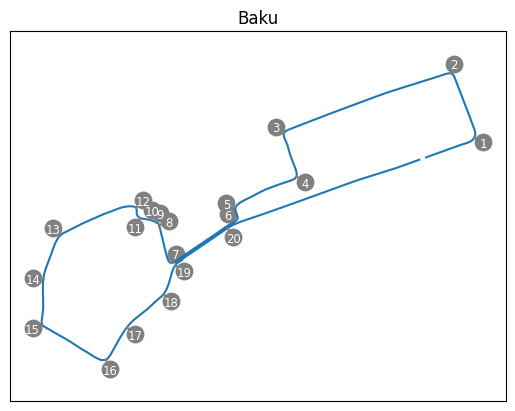

In [11]:
# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
    
plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()

### Speed

In [12]:
from matplotlib.collections import LineCollection

In [13]:
# driver = 'VER'
# lap = session.laps.pick_driver(driver).pick_fastest()

# Get telemetry data
x = lap.telemetry['X']              # values for x-axis
y = lap.telemetry['Y']              # values for y-axis
color = lap.telemetry['Speed']      # value to base color gradient on

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


In [14]:
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

from matplotlib import cm, colors, colorbar
colormap = cm.viridis_r

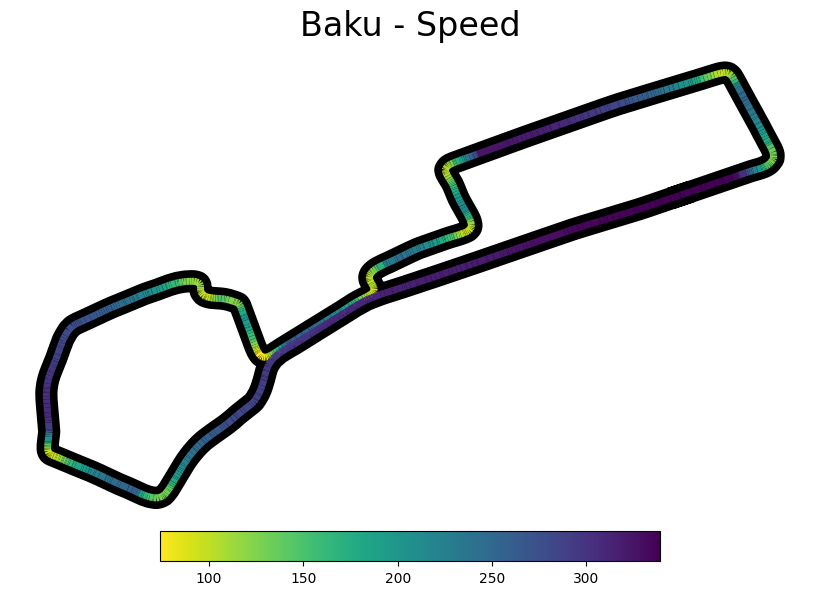

In [15]:
# We create a plot with title and adjust some setting to make it look good.
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 6))

fig.suptitle(f'{session.event['Location']} - Speed', size=24, y=0.97)

# Adjust margins and turn of axis
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

# After this, we plot the data itself.
# Create background track line
ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
        color='black', linestyle='-', linewidth=16, zorder=0)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm,
                    linestyle='-', linewidth=5)

# Set the values used for colormapping
lc.set_array(color)

# Merge all line segments together
line = ax.add_collection(lc)

# Finally, we create a color bar as a legend.
cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = colors.Normalize(vmin=color.min(), vmax=color.max())
legend = colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                   orientation="horizontal")

# Show the plot
plt.show()

Si me da tiempo hacer porcentaje acelerador, marchas, lo que sea. Poco prioritario.

---

## Ritmos de carrera

### Drivers

In [16]:
# Enable Matplotlib patches for plotting timedelta values and load
# FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [197]:
plot_drivers_pace(session, kind='compound')

In [220]:
plot_drivers_pace(session, kind='compound')

### Teams

In [147]:
plot_teams_pace(session, box=True)

Se puede cambiar a violin o swarm

---

## Tyre strat

In [149]:
drivers = session.drivers
print(drivers)

drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
print(drivers)

['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
['PIA', 'LEC', 'RUS', 'NOR', 'VER', 'ALO', 'ALB', 'COL', 'HAM', 'BEA', 'HUL', 'GAS', 'RIC', 'ZHO', 'OCO', 'BOT', 'PER', 'SAI', 'STR', 'TSU']


In [150]:
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()

stints = stints.rename(columns={"LapNumber": "StintLength"})

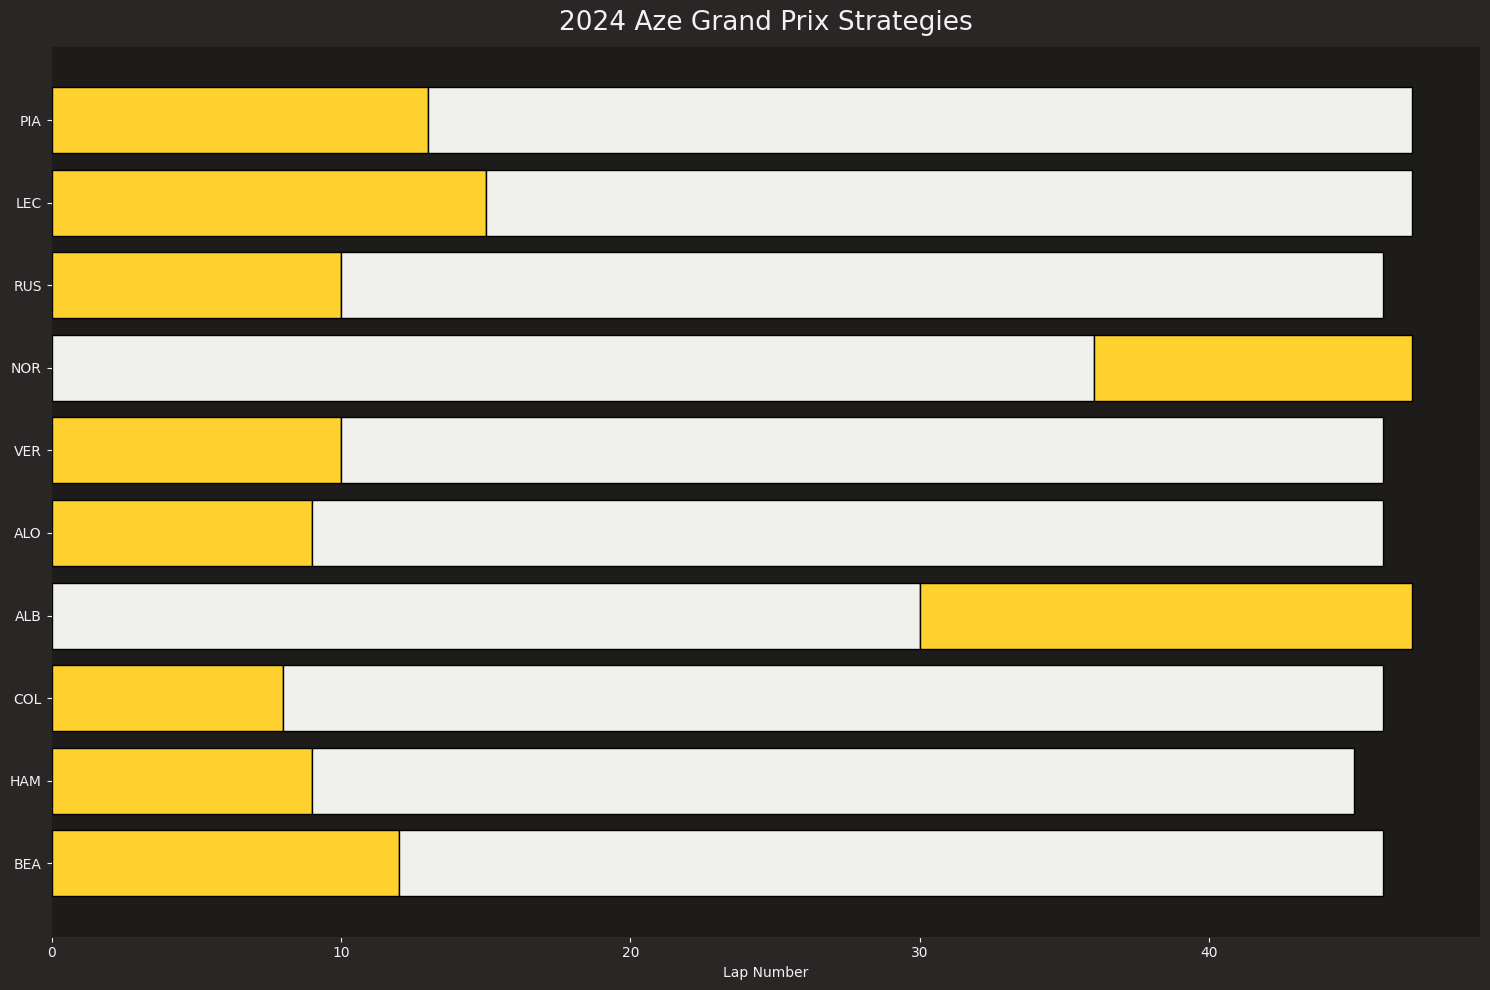

In [157]:
fig, ax = plt.subplots(figsize=(15, 10))

drivers = drivers[:10]

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        compound_color = fastf1.plotting.get_compound_color(row["Compound"],
                                                            session=session)
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

plt.title("2024 Aze Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

In [194]:
def plot_tyre_strat(session):

    drivers = session.drivers
    drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

    # Crear la figura de Plotly
    fig = go.Figure()

    for driver in drivers:
        driver_stints = stints.loc[stints["Driver"] == driver]
        previous_stint_end = 0

        for _, row in driver_stints.iterrows():
            # Obtener el color del compuesto
            compound_color = fastf1.plotting.get_compound_color(row["Compound"], session=session)
            
            # Añadir una barra horizontal para cada stint
            fig.add_trace(
                go.Bar(
                    y=[driver],
                    x=[row["StintLength"]],
                    base=previous_stint_end,
                    orientation='h',
                    marker=dict(color=compound_color, line=dict(color='black', width=1)),
                    legendgroup="Compound",
                    showlegend=False,
                    width=0.8
                )
            )
            
            previous_stint_end += row["StintLength"]

    # Configurar el diseño del gráfico
    fig.update_layout(
        title="2024 Aze Grand Prix Strategies",
        xaxis=dict(title="Lap Number"),
        yaxis=dict(title="", autorange='reversed'),
        plot_bgcolor='black',
        template='plotly_dark',
        margin=dict(t=40, b=40, l=40, r=40),
        bargap=1,
    )

    # Ocultar líneas de la cuadrícula y ejes
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)

    # Mostrar la figura
    fig.show()

plot_tyre_strat(session)

In [187]:
plot_tyre_strat(session)

In [198]:
import plotly.graph_objects as go

drivers = session.drivers
drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]


# Crear la figura de Plotly
fig = go.Figure()

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]
    previous_stint_end = 0

    for idx, row in driver_stints.iterrows():
        # Obtener el color del compuesto
        compound_color = fastf1.plotting.get_compound_color(row["Compound"], session=session)
        
        # Añadir una barra horizontal para cada stint
        fig.add_trace(
            go.Bar(
                y=[driver],
                x=[row["StintLength"]],
                base=previous_stint_end,
                orientation='h',
                marker=dict(color=compound_color, line=dict(color='black', width=1)),
                showlegend=False,
                width=0.8
            )
        )
        
        previous_stint_end += row["StintLength"]

# Configurar el diseño del gráfico
fig.update_layout(
    title="2024 Aze Grand Prix Strategies",
    xaxis=dict(title="Lap Number"),
    yaxis=dict(title="", autorange='reversed'),
    plot_bgcolor='black',
    template='plotly_dark',
    margin=dict(t=40, b=40, l=40, r=40),
    bargap=1,
)

# Ocultar líneas de la cuadrícula y ejes
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Mostrar la figura
fig.show()


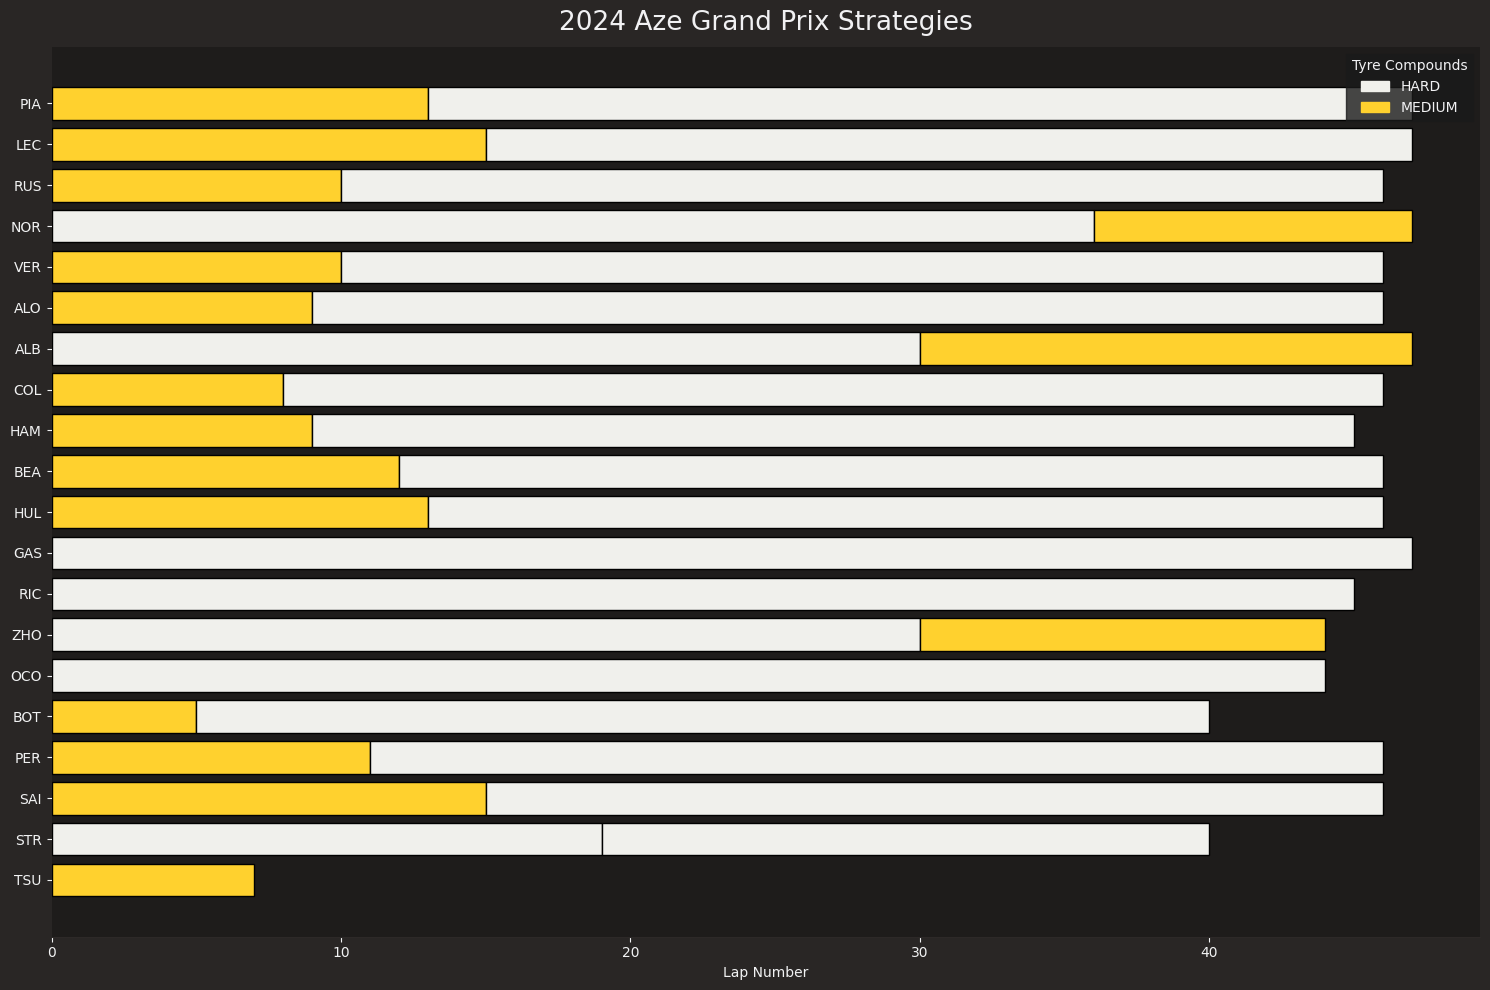

In [199]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15, 10))

# Crear un diccionario de colores y compuestos
compounds = stints['Compound'].unique()
compound_colors = [fastf1.plotting.get_compound_color(compound, session=session) for compound in compounds]

for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # Obtener el color del compuesto
        compound_color = fastf1.plotting.get_compound_color(row["Compound"], session=session)
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

plt.title("2024 Aze Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# Invertir el eje y para que los pilotos mejor clasificados estén en la parte superior
ax.invert_yaxis()

# Ocultar algunos bordes de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Crear la leyenda
legend_patches = [mpatches.Patch(color=color, label=compound) for compound, color in zip(compounds, compound_colors)]
plt.legend(handles=legend_patches, title="Tyre Compounds", loc="upper right")

plt.tight_layout()
plt.show()


---

## Qualy laps

In [200]:
# Enable Matplotlib patches for plotting timedelta values and load
# FastF1's dark color scheme
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

In [201]:
fastest_lap = session_qualy.laps.pick_fastest()
car_data = fastest_lap.get_car_data().add_distance()

In [202]:
circuit_info = session_qualy.get_circuit_info()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


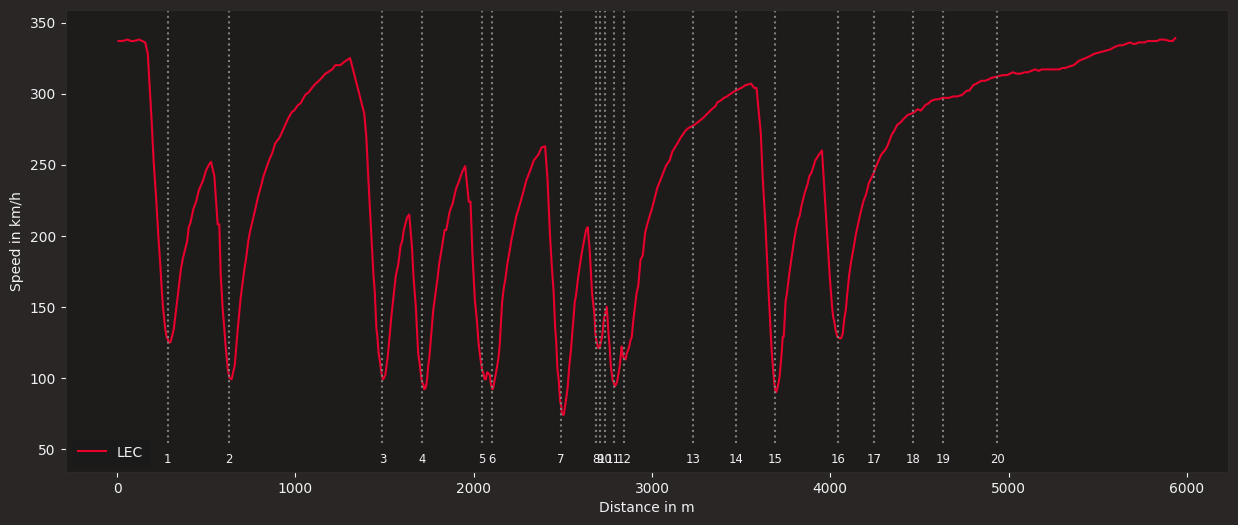

In [203]:
team_color = fastf1.plotting.get_team_color(fastest_lap['Team'],
                                            session=session)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(car_data['Distance'], car_data['Speed'],
        color=team_color, label=fastest_lap['Driver'])

# Draw vertical dotted lines at each corner that range from slightly below the
# minimum speed to slightly above the maximum speed.
v_min = car_data['Speed'].min()
v_max = car_data['Speed'].max()
ax.vlines(x=circuit_info.corners['Distance'], ymin=v_min-20, ymax=v_max+20,
          linestyles='dotted', colors='grey')

# Plot the corner number just below each vertical line.
# For corners that are very close together, the text may overlap. A more
# complicated approach would be necessary to reliably prevent this.
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], v_min-30, txt,
            va='center_baseline', ha='center', size='small')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')
ax.legend()

# Manually adjust the y-axis limits to include the corner numbers, because
# Matplotlib does not automatically account for text that was manually added.
ax.set_ylim([v_min - 40, v_max + 20])

plt.show()

### Dos pilotos

In [204]:
ver_lap = session_qualy.laps.pick_drivers(['VER']).pick_fastest()
ham_lap = session_qualy.laps.pick_drivers(['HAM']).pick_fastest()

In [205]:
ver_tel = ver_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

In [218]:
ver_tel

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance
0,2024-09-14 12:59:26.878,11928,340,8,100,False,12,car,0 days 00:00:00.119000,0 days 01:12:21.328000,11.238889
1,2024-09-14 12:59:27.158,12059,341,8,100,False,12,car,0 days 00:00:00.399000,0 days 01:12:21.608000,37.761111
2,2024-09-14 12:59:27.438,12042,340,8,100,False,12,car,0 days 00:00:00.679000,0 days 01:12:21.888000,64.205556
3,2024-09-14 12:59:27.638,12072,340,8,100,False,12,car,0 days 00:00:00.879000,0 days 01:12:22.088000,83.094444
4,2024-09-14 12:59:27.798,12072,340,8,100,False,12,car,0 days 00:00:01.039000,0 days 01:12:22.248000,98.205556
...,...,...,...,...,...,...,...,...,...,...,...
393,2024-09-14 13:01:07.638,11875,336,8,100,False,12,car,0 days 00:01:40.879000,0 days 01:14:02.088000,5827.265278
394,2024-09-14 13:01:07.878,11854,337,8,100,False,12,car,0 days 00:01:41.119000,0 days 01:14:02.328000,5849.731944
395,2024-09-14 13:01:08.198,11950,338,8,100,False,12,car,0 days 00:01:41.439000,0 days 01:14:02.648000,5879.776389
396,2024-09-14 13:01:08.438,11996,338,8,100,False,12,car,0 days 00:01:41.679000,0 days 01:14:02.888000,5902.309722


In [216]:
ver_tel['Speed']

0      340
1      341
2      340
3      340
4      340
      ... 
393    336
394    337
395    338
396    338
397    338
Name: Speed, Length: 398, dtype: int64

In [217]:
ham_tel['Speed']

0      338
1      339
2      339
3      339
4      339
      ... 
395    339
396    340
397    340
398    340
399    340
Name: Speed, Length: 400, dtype: int64

req            INFO 	Using cached data for driver_info


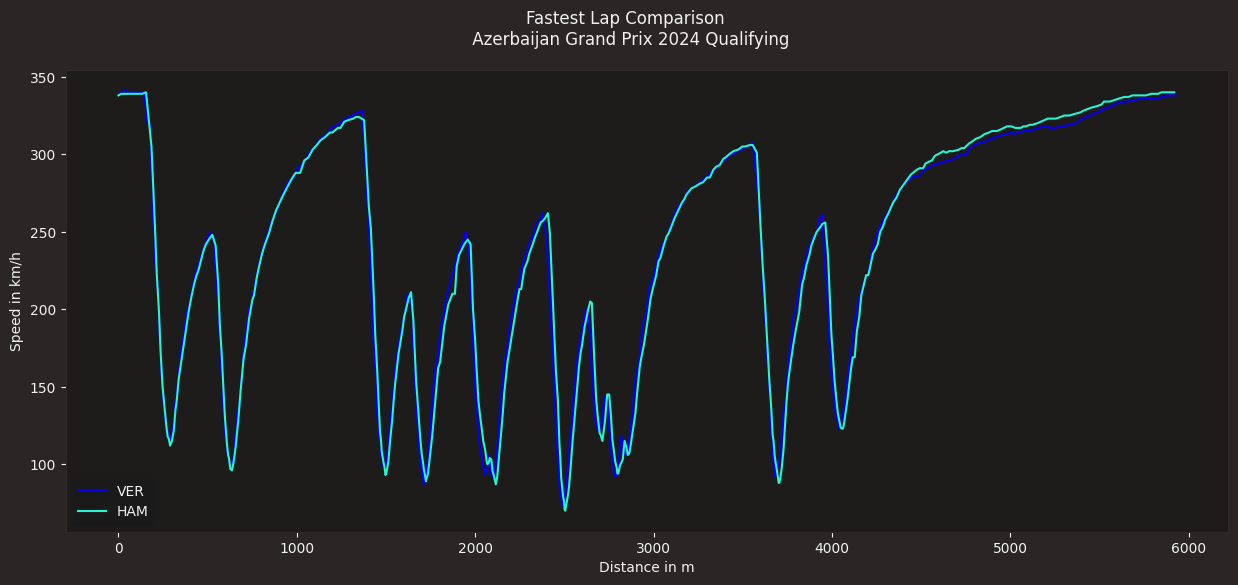

In [206]:
rbr_color = fastf1.plotting.get_team_color(ver_lap['Team'], session=session_qualy)
mer_color = fastf1.plotting.get_team_color(ham_lap['Team'], session=session_qualy)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label='HAM')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()

hacer la resta

### Qualy results

In [207]:
drivers = session_qualy.laps['Driver'].unique()

In [208]:
list_fastest_laps = []

for drv in drivers:
    drvs_fastest_lap = session.laps.pick_drivers([drv]).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)

In [209]:
from fastf1.core import Laps

fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

In [210]:
pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

In [211]:
team_colors = []

for _, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.get_team_color(lap['Team'], session=session_qualy)
    team_colors.append(color)

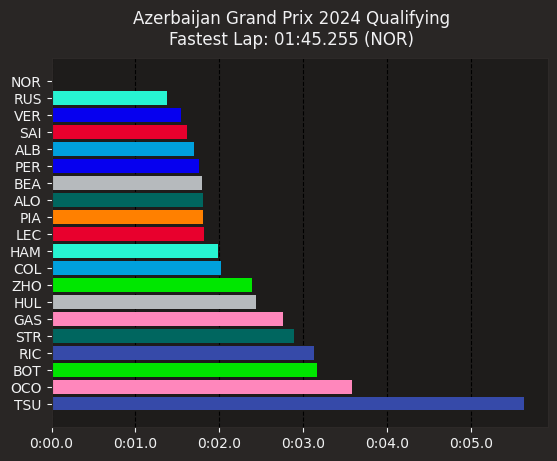

In [212]:
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors)
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = str(pole_lap['LapTime']).replace('0 days 00:', '').removesuffix('000')

plt.suptitle(f"{session_qualy.event['EventName']} {session_qualy.event.year} Qualifying\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

## Race results

In [213]:
drivers = session.laps['Driver'].unique()

In [214]:
df_results.reset_index(drop=True, inplace=True)

# El ganador tiene un delta de 0, lo voy a hardcodear
df_results.loc[0, 'Time'] = pd.Timedelta(0)

NameError: name 'df_results' is not defined

In [ ]:
df_results.head()

In [347]:
team_colors = df_results['TeamColor'].apply(lambda x: '#' + x).to_list()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.barh(df_results.index, df_results['Time'], color=team_colors)
ax.set_yticks(df_results.index)
ax.set_yticklabels(df_results['Abbreviation'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

plt.suptitle(f"{session.event['EventName']} {session.event.year} Race\n")

plt.show()

In [ ]:
# Gráfico de barras horizontales
plt.barh(df_results.index, df_results['Time'], color=team_colors)

# Etiquetas del eje y
plt.yticks(df_results.index, df_results['Abbreviation'])

# Mostrar el tiempo más rápido arriba
plt.gca().invert_yaxis()

# Dibujar líneas verticales detrás de las barras
plt.grid(axis='x', which='major', linestyle='--', color='black', zorder=-1000)

# Título del gráfico
plt.title(f"{session.event['EventName']} {session.event.year} Race\n")

# Mostrar el gráfico
plt.show()

Con Seaborn

In [ ]:
# Crear el gráfico de barras horizontales
sns.barplot(
    y=df_results['Abbreviation'],
    x=df_results['Time'], 
    orient="y",
    palette=team_colors
)

# Título del gráfico
plt.title(f"{session.event['EventName']} {session.event.year} Race\n")

# Mostrar el gráfico
plt.show()

Con Plotly

In [ ]:
import plotly.express as px

# Configurar esquema de colores oscuro de FastF1
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False, color_scheme='fastf1')

# Crear el gráfico de barras horizontales
fig = px.bar(
    df_results,
    y='Abbreviation',  # Etiquetas en el eje y
    x=df_results['Time'].dt.total_seconds(),          # Valores de las barras
    color='Abbreviation',  # Usar una columna como base para los colores
    color_discrete_sequence=team_colors,  # Colores personalizados
    orientation='h'    # Orientación horizontal
)

# Ajustar el diseño para invertir el eje y
fig.update_layout(
    title=f"{session.event['EventName']} {session.event.year} Race",
    xaxis_title="Time (s)",
    yaxis_title="Abbreviation",
    xaxis=dict(tickvals=list(range(0, 150, 10))),
    plot_bgcolor='black',  # Fondo del gráfico
    paper_bgcolor='black',  # Fondo general
    font=dict(color='white')  # Texto general en blanco
)

# Mostrar el gráfico
fig.show()


---

### Drivers race pace

In [374]:
driver_laps = session.laps.pick_drivers(["ALO"]).pick_quicklaps().reset_index()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(data=driver_laps,
                x="LapNumber",
                y="LapTime",
                ax=ax,
                hue="Compound",
                palette=fastf1.plotting.get_compound_mapping(session=session),
                s=80,
                linewidth=0,
                legend='auto')

ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

# The y-axis increases from bottom to top by default
# Since we are plotting time, it makes sense to invert the axis
ax.invert_yaxis()
plt.suptitle("Alonso Laptimes in the 2024 Azerbaijan Grand Prix")

# Turn on major grid lines
plt.grid(color='w', which='major', axis='both')
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

### Driver comparison

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

for driver in ('HAM', 'PER', 'VER', 'RUS'):
    laps = session.laps.pick_drivers([driver]).pick_quicklaps().reset_index()
    style = fastf1.plotting.get_driver_style(identifier=driver,
                                      style=['color', 'linestyle'],
                                      session=session)
    ax.plot(laps['LapTime'], **style, label=driver)

# add axis labels and a legend
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")
fastf1.plotting.add_sorted_driver_legend(ax, race)

---

## Telemetría

In [ ]:
session.load()

In [ ]:
#load best lap from driver
LapNor = session.laps.pick_drivers(["NOR"]).pick_fastest()
LapVer = session.laps.pick_drivers(["VER"]).pick_fastest()
LapHam = session.laps.pick_drivers(["HAM"]).pick_fastest()

#get telemetry of each lap
NOR = LapNor.get_telemetry()
VER = LapVer.get_telemetry()
HAM = LapHam.get_telemetry()

In [ ]:
NOR["Brake"] = NOR["Brake"].replace({True: 100, False: 0})
NOR["Pedal"] = NOR["Throttle"] - NOR["Brake"]
HAM["Brake"] = HAM["Brake"].replace({True: 100, False: 0})
HAM["Pedal"] = HAM["Throttle"] - HAM["Brake"]
VER["Brake"] = VER["Brake"].replace({True: 100, False: 0})
VER["Pedal"] = VER["Throttle"] - VER["Brake"]

In [ ]:
rbr_color = fastf1.plotting.get_team_color(ver_lap['Team'], session=session_qualy)
mer_color = fastf1.plotting.get_team_color(ham_lap['Team'], session=session_qualy)

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(VER['Distance'], VER['Pedal'], color=rbr_color, label='VER')
ax.plot(HAM['Distance'], HAM['Pedal'], color=mer_color, label='HAM')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()